# **Instrument to Instrument (ITI) translation: SDO/HMI-to-Hinode continuum**

## Read The Docs
For more information about the tool and background of the individual case studies see:

[iti-documentation.rtfd.io](https://iti-documentation.readthedocs.io/en/latest/)

The Instrument-to-Instrument (ITI) translation tool can perform image domain translations between two different instruments. This allows ITI to be used for image enhancement, instrument intercalibration, and super-resolution observations in different scientific fields. For heliophysics, ITI has been applied to several instruments of various space-based and ground-based solar telescopes.

This colab notebook provides an example of translation for the image enhancement case study by applying ITI for translation between the **SDO/HMI** instrument and **Hinode/SOT**. Here we super-resolve HMI observations with 4096x4096 pixels by a factor 4. The model was trained with observations from Hinode/SOT to infer the resolution increase.

## Installation

In [1]:
!pip install git+https://github.com/spaceml-org/InstrumentToInstrument.git@development
!pip install lightning
!pip install sunpy_soar
!pip install sunpy

  Cloning https://github.com/spaceml-org/InstrumentToInstrument.git (to revision development) to /private/var/folders/tj/7h3lqn950sv5k36g1yyl4vkr0000gn/T/pip-req-build-l555zlfw
  Running command git clone --filter=blob:none --quiet https://github.com/spaceml-org/InstrumentToInstrument.git /private/var/folders/tj/7h3lqn950sv5k36g1yyl4vkr0000gn/T/pip-req-build-l555zlfw
  Running command git checkout -b development --track origin/development
  Switched to a new branch 'development'
  Branch 'development' set up to track remote branch 'development' from 'origin'.
  Resolved https://github.com/spaceml-org/InstrumentToInstrument.git to commit b083c705d463997caebf2df663d8774cbe569eda
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1

## Imports

In [2]:
from iti.download.download_hmi_continuum import HMIContinuumDownloader
from iti.translate import *
from datetime import datetime
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

## Download data

We start by downloading FITS files from SDO/HMI continuum. ITI provides a download routines for multiple data sets, here we utilize the HMIContinuumDownloader. We download an observation from 2021-09-09.

In [3]:
fetcher = HMIContinuumDownloader(ds_path='hmi', email='chri.schirni@hotmail.de', num_worker_threads=4)
hmi_files = fetcher.fetchDates([datetime(2021, 9, 9, 15)])
print('downloaded:', hmi_files)

INFO:root:Fetch header information
INFO:root:Download data


downloaded: ['hmi/2021-09-09T15:00:00.fits']


For later comparison we load the HMI FITS file as SunPy Map.

In [4]:
hmi_map = Map(hmi_files[0])
hmi_map.data[np.isnan(hmi_map.data)] = 0

The translator classes are the core element of the ITI translation. They follow the notation: InstrumentAToInstrumentB. For HMI files we need to translate the image in patches (patch_factor=3), otherwise we would exceed the memory.

The first initialization of each translator triggers the download of the pre-trained model and stores it locally for later use.

In [5]:
translator = HMIToHinode(patch_factor=3)

The translate function starts the translation process of the HMI FITS files and returns a genartor object. This can be used to sequentially process the results. Here we only translate a single file and convert the generator object to a list.

In [6]:
iti_hmi_map = list(translator.translate(hmi_files))[0]

The result of the ITI translation is a SunPy map that stores all necessary coordinate information. We can compare this map to the original HMI observation.

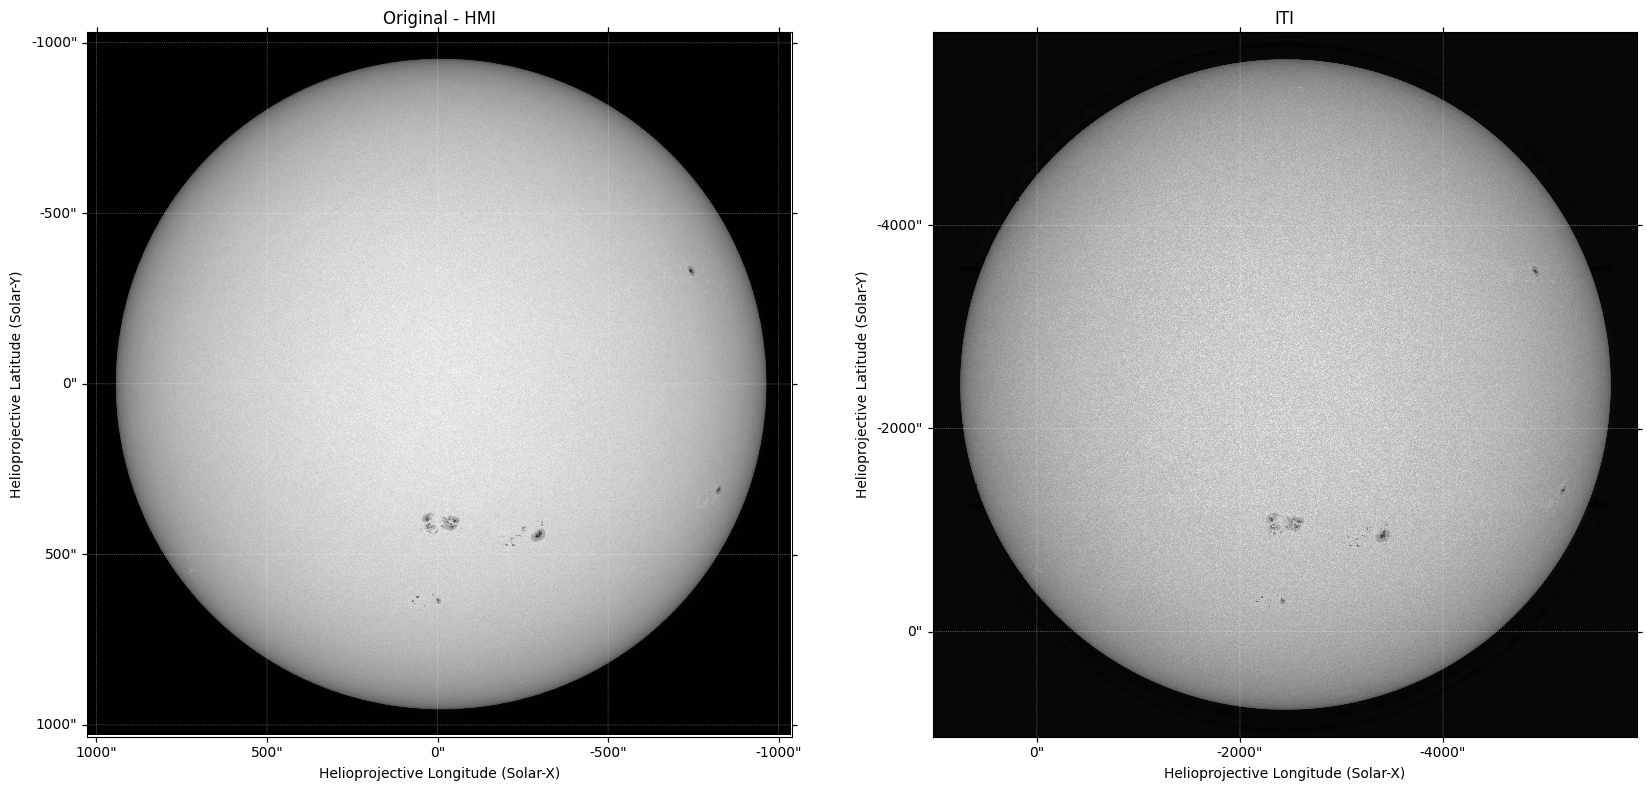

In [7]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': hmi_map},  figsize=(20, 10))
hmi_map.rotate().plot(axes=axs[0])
axs[0].set_title('Original - HMI')
iti_hmi_map.plot(axes=axs[1])
axs[1].set_title('ITI')
plt.show()
plt.close()

For a comparison at smaller scales we can specify a subframe and plot the images side-by-side.

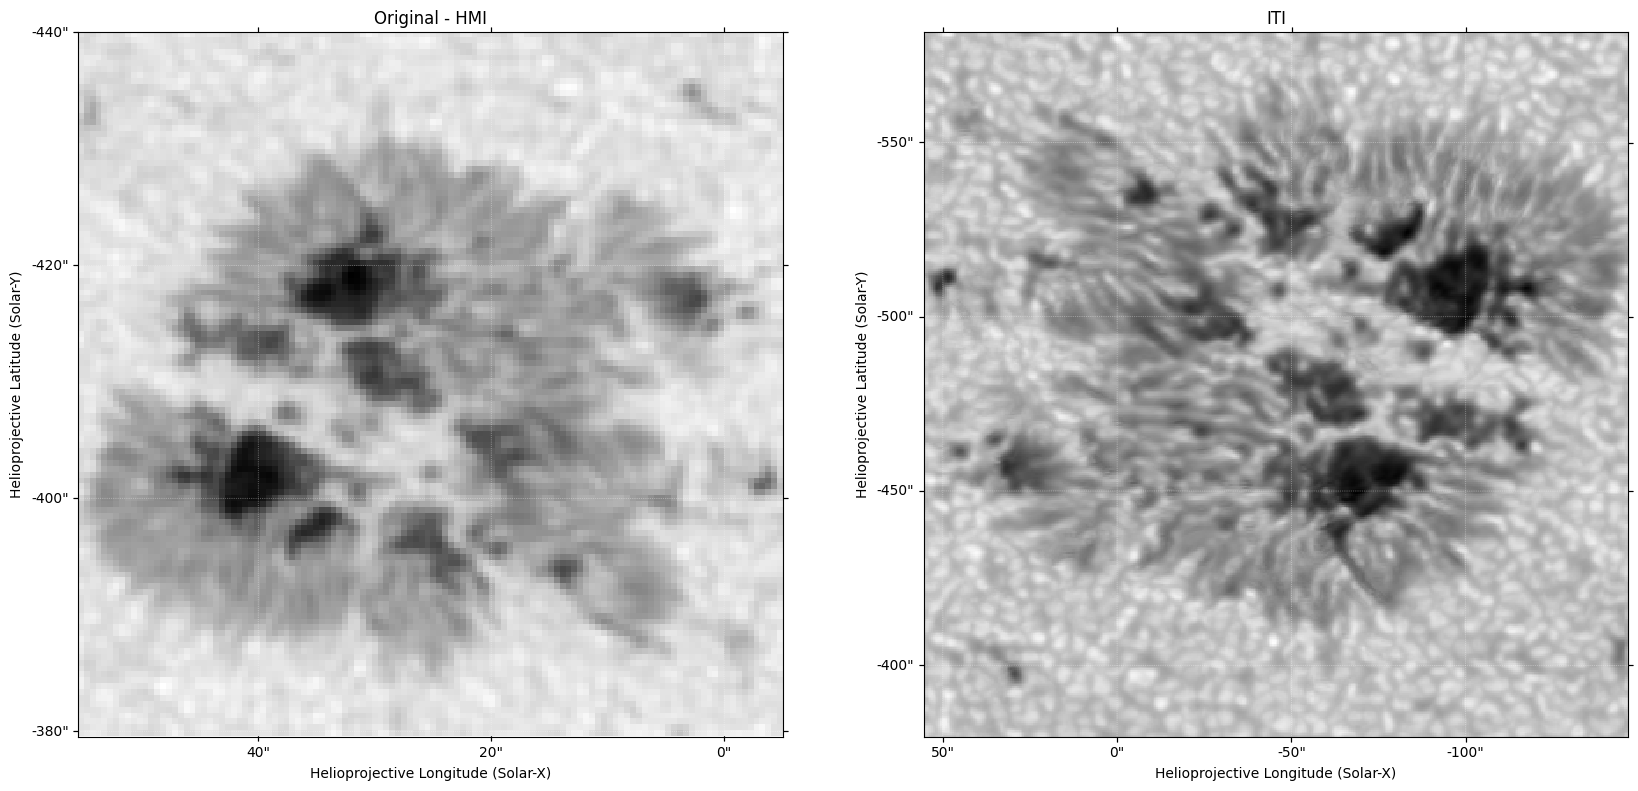

In [8]:
bl = SkyCoord(-5 * u.arcsec, -440 * u.arcsec, frame=hmi_map.coordinate_frame)
tr = SkyCoord(55 * u.arcsec, -380 * u.arcsec, frame=hmi_map.coordinate_frame)

fig, axs = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': hmi_map.submap(bl, top_right=tr)})
hmi_map.submap(bl, top_right=tr).plot(axes=axs[0])
axs[0].set_title('Original - HMI')
iti_hmi_map.submap(bl, top_right=tr).plot(axes=axs[1])
axs[1].set_title('ITI')
plt.show()